<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter8FocalImaging/highPassFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High pass filtering of incoherent imagers




## David Brady
## University of Arizona

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.decomposition import PCA
from scipy.interpolate import BSpline
from scipy.integrate import quad
from scipy.signal import resample
plt.rcParams['figure.figsize'] = [15,7]
plt.rcParams['font.size']= 22

We consider sampling of the object distribution $f(x,y)$ using low pass and  high pass PSFs. The measurements are
$$g_1(x',y')=\int h_1(x'-x,y'-y)f(x,y) dx dy$$
and
$$g_2(x',y')=\int h_2(x'-x,y'-y)f(x,y) dx dy$$
We estimate the spectrum of $f(x,y)$, ${\hat f}(u,v)$ according to
$${\hat f}_{\rm est}(u,v)= w_1(u,v){\hat g}_1(u,v)+w_2(u,v){\hat g}_2(u,v)$$
where as with the Weiner filter select $w_1(u,v)$ and $w_2(u,v)$ to minimize the mean square error
$$
\begin{array}[c]{rl}
\epsilon(u)&= \left \langle |{\hat f}-{\hat f}_{\rm est}|^2\right \rangle\\
&= |1-{\hat w}_1(u){\hat h}_1(u)-{\hat w}_2(u){\hat h}_2(u)|^2S_f(u)+|{\hat w}_1|^2S_{n_1}(u)+|{\hat w}_2|^2S_{n_2}(u)
\end{array}
$$
We find
$$\frac{\partial \epsilon}{\partial w_1}= \left (-h_1+w_1^\ast|h_1|^2+w_2^\ast h_1h_2^\ast \right ) S_f+ w_1^\ast S_{n_1}$$
$$\frac{\partial \epsilon}{\partial w_2}= \left (-h_2+w_2^\ast|h_2|^2+w_1^\ast h_1^\ast h_2 \right ) S_f+ w_2^\ast S_{n_2}$$
at the extremum,
$$w_1^\ast=\frac{ \left (h_1 -w_2^\ast h_1h_2^\ast \right ) S_f}{\left (|h_1|^2S_f+S_{n_1}\right )} $$
$$\left (-h_2+w_2^\ast|h_2|^2+\frac{ \left (h_1-w_2^\ast h_1h_2^\ast \right ) S_f}{\left (|h_1|^2S_f+S_{n_1}\right )} h_1^\ast h_2 \right ) S_f+ w_2^\ast S_{n_2}=0$$
$$
w_2S_f|h_2|^2\left( 1-\frac{ |h_1|^2  S_f}{\left (|h_1|^2S_f+S_{n_1}\right )}+\frac{S_{n_2}}{|h_2|^2S_f}\right )= h_2^\ast S_f\left (1-\frac{ |h_1|^2  S_f}{\left (|h_1|^2S_f+S_{n_1}\right )}\right )
$$
so
$$
w_1=  \frac{h_1^\ast }{|h_1|^2}\frac{1-\frac{ |h_2|^2  S_f}{\left (|h_2|^2S_f+S_{n_2}\right )}}{\left( 1-\frac{ |h_2|^2  S_f}{\left (|h_2|^2S_f+S_{n_2}\right )}+\frac{S_{n_1}}{|h_1|^2S_f}\right )}
$$
$$
w_1=  \frac{h_1^\ast }{|h_1|^2}\frac{1}{\left(1+\frac{|h_2|^2S_{n_1}}{|h_1|^2S_{n_2}}\left (1+\frac{S_{n_2}}{|h_2|^2 S_f}\right )\right )}
$$
and
$$
w_2=  \frac{h_2^\ast }{|h_2|^2}\frac{1}{\left(1+\frac{|h_1|^2S_{n_2}}{|h_2|^2S_{n_1}}\left (1+\frac{S_{n_1}}{|h_1|^2 S_f}\right )\right )}
$$



In [ ]:


def overlap_area(a, b, c):
    """
    Calculate the area of overlap between two circles of radii `a` and `b` with distance `c` between their centers.

    Parameters:
    a (float): Radius of the first circle.
    b (float): Radius of the second circle.
    c (float): Distance between the centers of the circles.

    Returns:
    float: Area of the overlap between the two circles.
    """
    # No overlap condition
    if c >= a + b:
        return 0.0
    # One circle is fully inside the other
    elif c <= abs(a - b):
        return np.pi * np.min([a, b])**2

    # Calculate the area of overlap when circles partially overlap
    term1 = a**2 * np.arccos((c**2 + a**2 - b**2) / (2 * c * a))
    term2 = b**2 * np.arccos((c**2 + b**2 - a**2) / (2 * c * b))
    term3 = 0.5 * np.sqrt((-c + a + b) * (c + a - b) * (c - a + b) * (c + a + b))

    return term1 + term2 - term3
ov=np.vectorize(overlap_area)



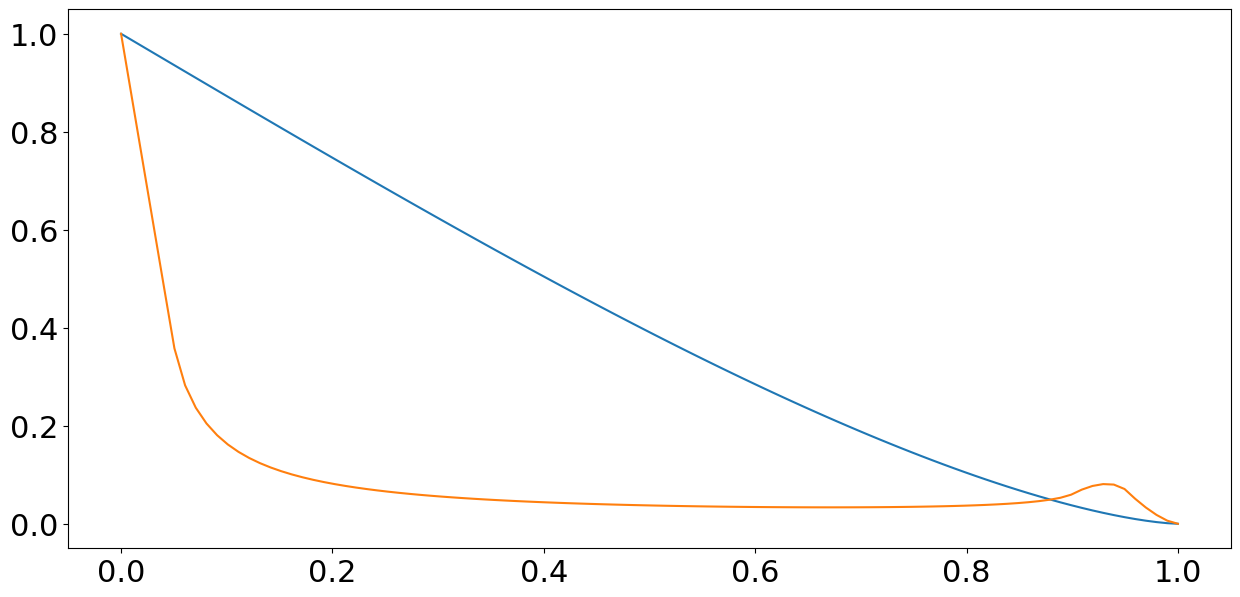

In [ ]:
x=np.linspace(0,1,100)
plt.plot(x,ov(.5,.5,x)/ov(.5,.5,0))
plt.plot(x,(ov(.5,.5,x)+ov(.45,.45,x)-2*ov(.5,.45,x))/(ov(.5,.5,0)+ov(.45,.45,0)-2*ov(.5,.45,0)))


In [ ]:
def h1(u):
  otf=ov(.5,.5,u)
  return otf
def h2(u, r):
  otf=ov(.5,.5,u)+ov(r*.5,r*.5,u)-2*ov(.5,r*.5,u)
  return otf
def w1(u, r,snr):
  h1l=h1(u)
  h2l=h2(u,r)
  sn=h2(0,r)/h1(0)
  w1=1/(h1l*(1+(h2l**2/(sn*h1l**2))*(1+sn/((h2l**2)*snr))))
  return w1
def w2(u, r,snr):
  h1l=h1(u)
  h2l=h2(u,r)
  sn=h2(0,r)/h1(0)
  w2=1/(h2l*(1+((h1l**2)*sn/(h2l**2))*(1+1/((h2l**2)*snr))))
  return w2
def erra(u,r,snr):
  h1l=h1(u)
  h2l=h2(u,r)
  sn=h2(0,r)/h1(0)
  err=np.abs(1-w1(u,r,snr)*h1l-w2(u,r,snr)*h2l)**2+np.abs(w1(u,r,snr))**2/snr+sn*np.abs(w2(u,r,snr))**2/snr
  return err
def errc(u,snr):
  h1l=h1(u)
  err=1/(1+snr*h1l**2)
  return err
def err2(u,r,snr):
  h2l=h2(u,r)
  sn=h2(0,r)/h1(0)
  err=1/(1+(snr*h2l**2)/sn)
  return err

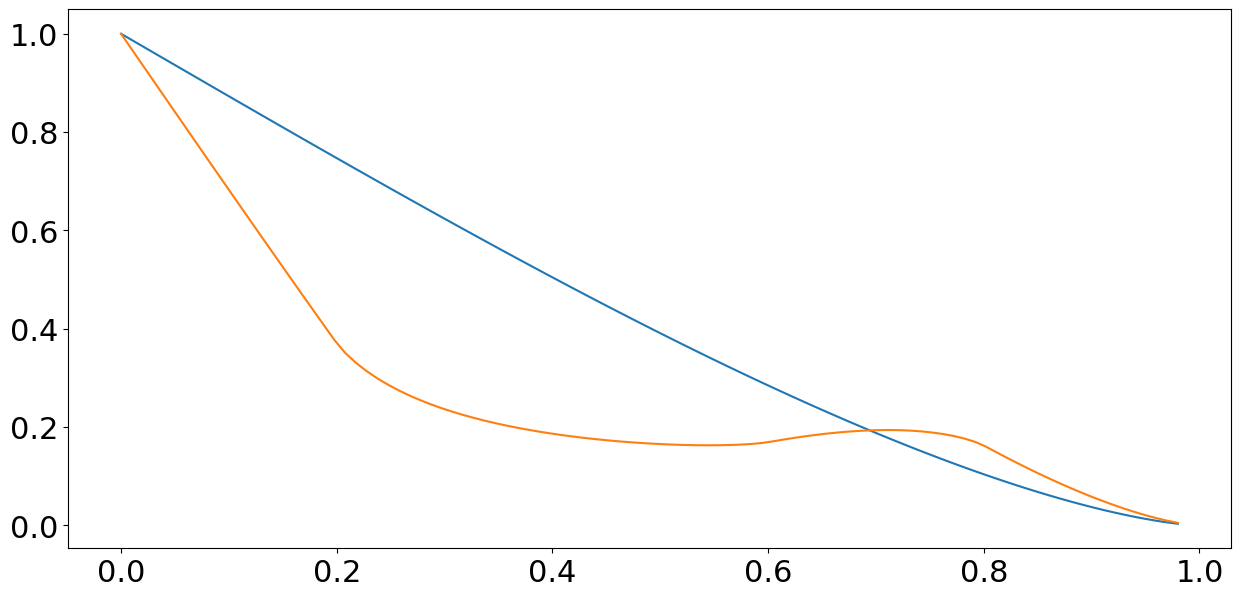

In [ ]:
x=np.linspace(0,.98,100)
plt.plot(x,h1(x)/h1(0))
plt.plot(x,h2(x,.6)/h2(0,.6))


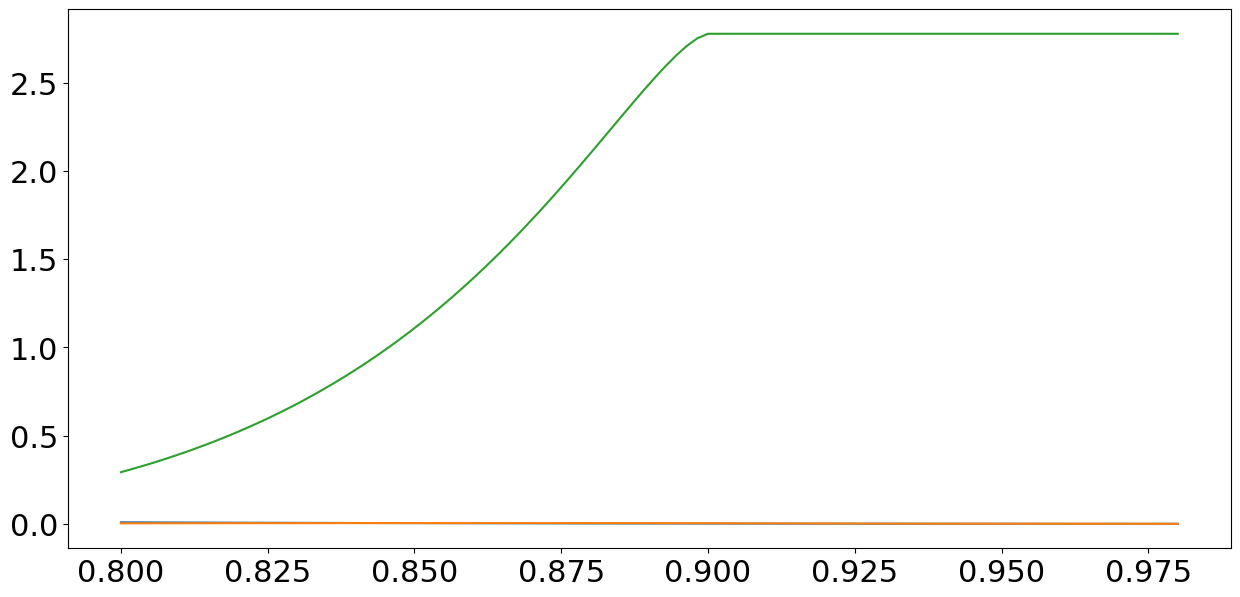

In [ ]:
x=np.linspace(.8,.98,100)
plt.plot(x,h1(x)**2/h1(0))
plt.plot(x,h2(x,.8)**2/h2(0,.8))
plt.plot(x,(h2(x,.8)**2/h2(0,.8))/(h1(x)**2/h1(0)))

<ipython-input-7-84564a410a68>:11: RuntimeWarning: invalid value encountered in divide
  w1=1/(h1l*(1+(h2l**2/(sn*h1l**2))*(1+sn/((h2l**2)*snr))))
<ipython-input-7-84564a410a68>:11: RuntimeWarning: divide by zero encountered in divide
  w1=1/(h1l*(1+(h2l**2/(sn*h1l**2))*(1+sn/((h2l**2)*snr))))
<ipython-input-7-84564a410a68>:17: RuntimeWarning: invalid value encountered in divide
  w2=1/(h2l*(1+((h1l**2)*sn/(h2l**2))*(1+1/((h2l**2)*snr))))
<ipython-input-7-84564a410a68>:17: RuntimeWarning: divide by zero encountered in divide
  w2=1/(h2l*(1+((h1l**2)*sn/(h2l**2))*(1+1/((h2l**2)*snr))))


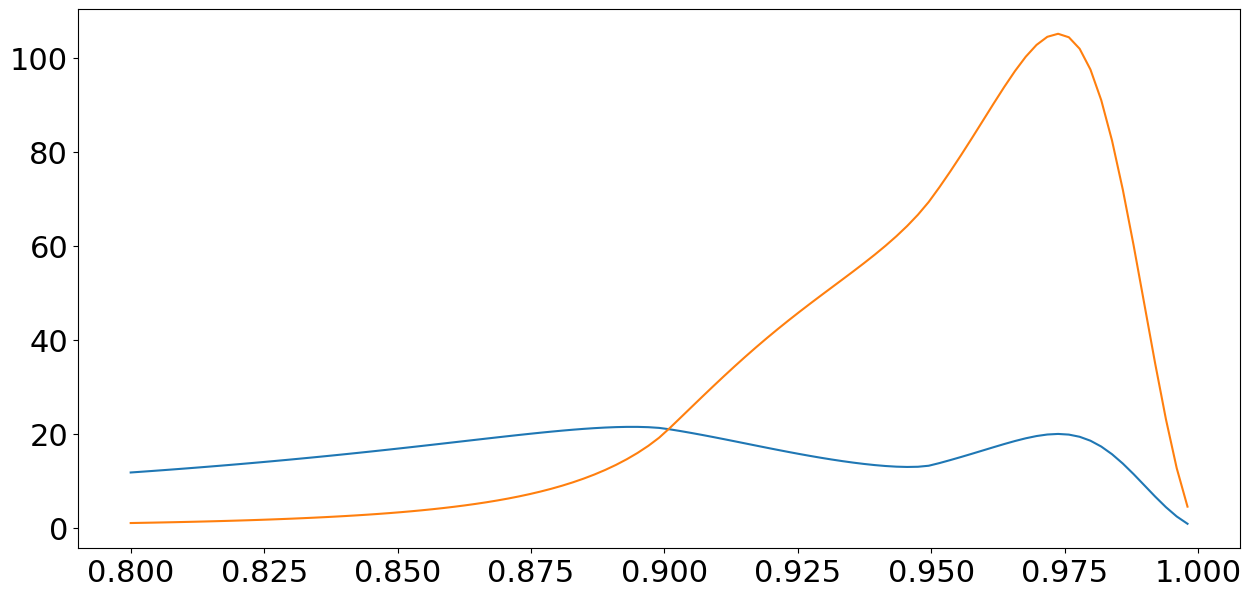

In [ ]:
u=np.linspace(.8,1,100)
plt.plot(u,w1(u,.9,10000))
plt.plot(u,w2(u,.9,10000))

<Figure size 1500x700 with 0 Axes>

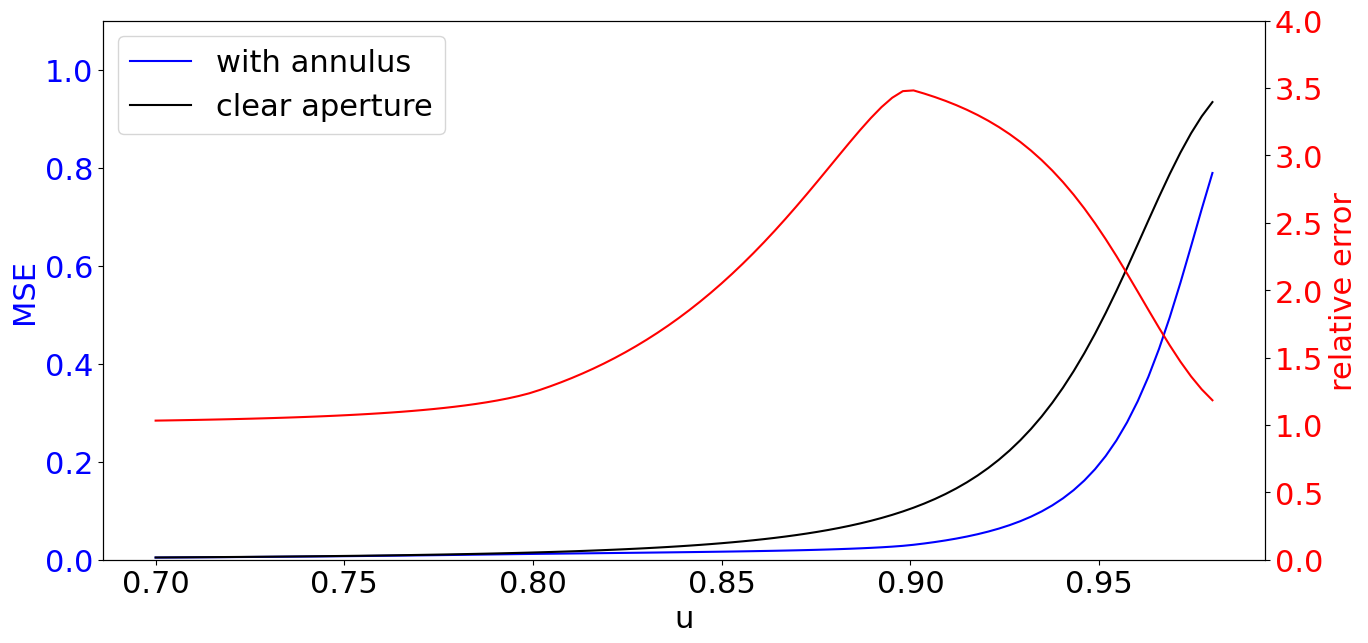

In [ ]:
plt.figure(figsize=(15,7))
u=np.linspace(.7,.98,100)

# Create a figure and axis with a secondary y-axis
fig, ax1 = plt.subplots()

# Plot f(x) on the primary y-axis
ax1.plot(u, erra(u,.8,10000), color='blue', label='with annulus')
ax1.plot(u, errc(u,10000), color='black', label='clear aperture')
ax1.set_xlabel('u')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.1)  # Scale for f(x)
plt.legend(loc='upper left')

# Create a secondary y-axis for g(y)
ax2 = ax1.twinx()
ax2.plot(u, errc(u,10000)/erra(u,.8,10000), color='red')
ax2.set_ylabel('relative error', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 4)  # Scale for g(y)
plt.savefig('annulusError.pdf')

In [ ]:
.8*

0.014742406352143203

In [ ]:
erra(.8,.8,10000)

0.011856843100096933

## Fourier sampling

In [ ]:
# prompt: make a 3d surface plot of u -v over the plane with u going from -.5 to .5 and v going from -.5 to .5


def r(x):
  if np.abs(x)<.5:
    return 1
  else:
    return 0
rect=np.vectorize(r)

def convolve_rects(a, b, x_values):
    """
    Compute the convolution of two rect functions centered at zero with widths a and b.

    Parameters:
    - a: Width of the first rect function.
    - b: Width of the second rect function.
    - x_values: Array of x values where the convolution is evaluated.

    Returns:
    - h_values: The convolution evaluated at x_values.
    """
    # Compute the overlap at each x
    left = np.maximum(-a/2, x_values - b/2)
    right = np.minimum(a/2, x_values + b/2)
    overlap = right - left
    h_values = np.maximum(0, overlap)
    return h_values


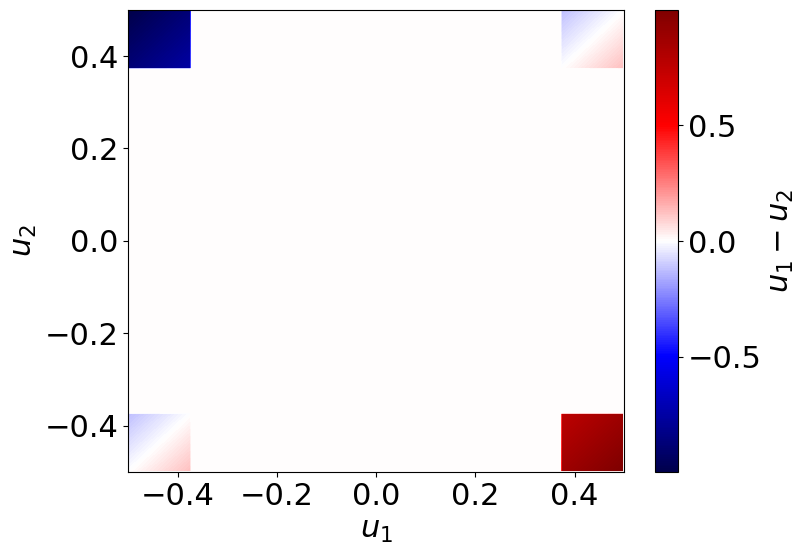

In [ ]:
def surface_function(u, v):
    return (u - v)*(rect(u)-rect(u/.75))*(rect(v)-rect(v/.75))

# Define the range for u and v
u_min, u_max = -0.5, 0.5
v_min, v_max = -0.5, 0.5

# Number of points in each dimension
num_points = 500

# Create a grid of u and v values
u = np.linspace(u_min, u_max, num_points)
v = np.linspace(v_min, v_max, num_points)
U, V = np.meshgrid(u, v)



# Compute the function values over the grid
Z = surface_function(U, V)

# Create the density plot
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=(u_min, u_max, v_min, v_max), origin='lower', cmap='seismic', aspect='auto')
plt.colorbar(label=r'$u_1-u_2$')
#plt.title('Density Plot of surface_function(u, v)')
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')
plt.savefig('Juv2.pdf')


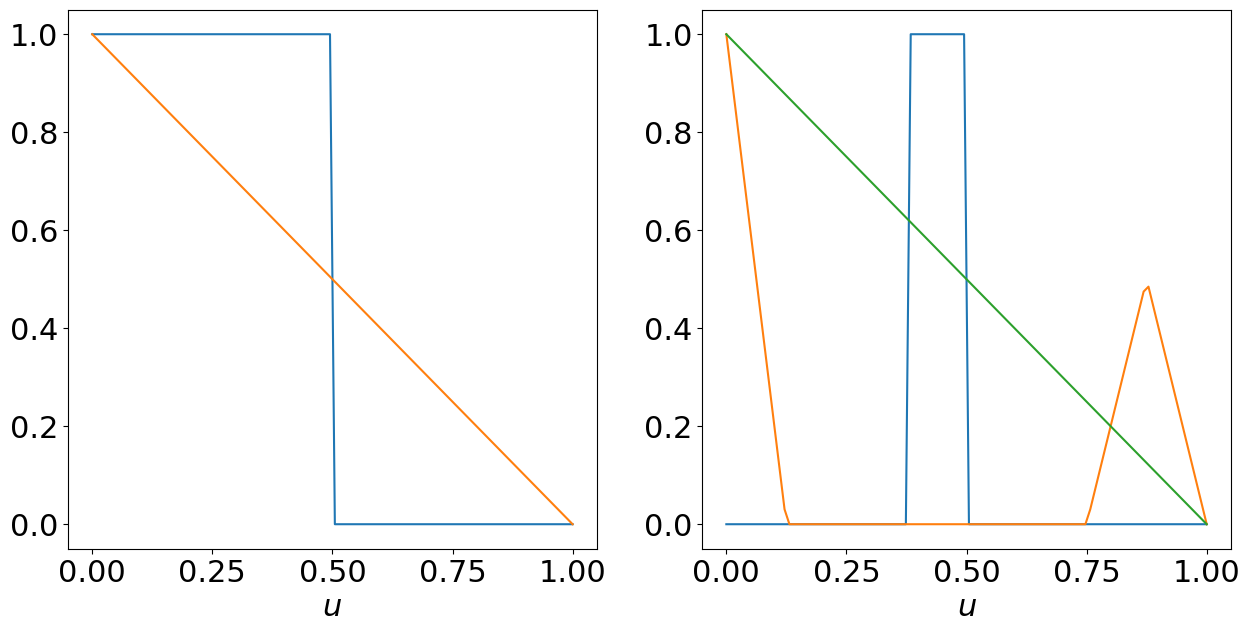

In [ ]:
def p(u):
  p=rect(u)
  return p
def otf(u):
  p=convolve_rects(1,1,u)
  return p
u=np.linspace(0,1,100)
plt.subplot(1,2,1)
plt.plot(u,p(u), u,otf(u))
plt.xlabel(r'$u$')
plt.subplot(1,2,2)
w=.75
plt.plot(u,rect(u)-rect(u/w),u,(convolve_rects(1,1,u)+convolve_rects(w,w,u)-2*convolve_rects(1,w,u))/(1-w))
plt.xlabel(r'$u$')
plt.plot(u,otf(u))
plt.savefig('otf1Dannulus.pdf')